In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
import networkx as nx

warnings.filterwarnings('ignore')


# Helping Functions

In [2]:
def calculate_rule_support(df: pd.DataFrame, body_and_head_values:dict[str, str]) -> float:
    """Calculates the support of the rule 

    Args:
        df (pd.DataFrame): dataframe to calculate the support
        body_and_head_values (dict[str, str]): dictionary containing the column names and values of the rule

    Returns:
        float: support of the rule
    """
    no_of_rows = df.shape[0]
    support = 0
    for i in range(no_of_rows):
        is_rule_satisfied = True
        for column, value in body_and_head_values.items():
            if df[column][i] != value:
                is_rule_satisfied = False
                break
        if is_rule_satisfied:
            support += 1
    if no_of_rows == 0:
        return 0
    return support/no_of_rows

def calculate_rule_confidence(df: pd.DataFrame, body_values : dict[str, str], head_values : dict[str, str]) -> float:
    """calculates the confidence of the rule

    Args:
        df (pd.DataFrame): dataframe to calculate the confidence
        body_values (dict[str, str]): dictionary containing the column names and values of the body of the rule
        head_values (dict[str, str]): dictionary containing the column names and values of the head of the rule

    Returns:
        float: confidence of the rule
    """
    no_of_rows = df.shape[0]
    body_support = calculate_rule_support(df, body_values)
    Whead_support = calculate_rule_support(df, head_values)
    body_head_support = calculate_rule_support(df, {**body_values, **head_values})
    if body_support == 0:
        return 0
    return body_head_support/body_support

def calculate_rule_lift(df: pd.DataFrame, body_values : dict[str, str], head_values : dict[str, str]) -> float:
    """calculates the lift of the rule

    Args:
        df (pd.DataFrame): dataframe to calculate the lift
        body_values (dict[str, str]): dictionary containing the column names and values of the body of the rule
        head_values (dict[str, str]): dictionary containing the column names and values of the head of the rule

    Returns:
        float: lift of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    head_support = calculate_rule_support(df, head_values)
    body_head_support = calculate_rule_support(df, {**body_values, **head_values})
    if body_support == 0 or head_support == 0:
        return 0
    return body_head_support/(body_support*head_support)

def rule_info(df: pd.DataFrame, body_values : dict[str, str], head_values : dict[str, str]) -> dict[str, float]:
    """calculates the support, confidence and lift of the rule

    Args:
        df (pd.DataFrame): dataframe to calculate the rule info
        body_values (dict[str, str]): dictionary containing the column names and values of the body of the rule
        head_values (dict[str, str]): dictionary containing the column names and values of the head of the rule

    Returns:
        dict[str, float]: dictionary containing the support, confidence and lift of the rule
    """
    return {
        "support": calculate_rule_support(df, {**body_values, **head_values}),
        "confidence": calculate_rule_confidence(df, body_values, head_values),
        "lift": calculate_rule_lift(df, body_values, head_values)
    }
    
def create_encoder(df : pd.DataFrame, categorical_cols : list[str]) -> tuple[OneHotEncoder, list[str], list[dict[str, str]]]:
    """Creates an encoder for the categorical columns of the dataframe

    Args:
        df (pd.DataFrame): dataframe to create the encoder
        categorical_cols (list[str]): list of categorical columns

    Returns:
        tuple[OneHotEncoder, list[str], list[dict[str, str]]]: OneHotEncoder for categorical columns
    """
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df[categorical_cols])
    encoded_feature_cols = encoder.get_feature_names_out(categorical_cols)
    feature_groups = []
    
    for col_1 in encoded_feature_cols:
        col_1_cat = col_1.rsplit('_', 1)[0]
        for cat in categorical_cols:
            if col_1_cat == cat and cat not in [group['variable'] for group in feature_groups]:
                feature_groups.append({'variable': cat, 'columns': [col_2 for col_2 in encoded_feature_cols if col_2.rsplit('_', 1)[0] == cat]})
                    
    return encoder, encoded_feature_cols, feature_groups
    

def one_hot_encode_df(df: pd.DataFrame, categorical_cols : list[str], encoder = OneHotEncoder) -> pd.DataFrame:
    """One hot encodes the categorical columns of the dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        categorical_cols (list[str]): columns to encode
        encoder (_type_, optional): en. Defaults to OneHotEncoder.

    Returns:
        pd.DataFrame: encoded dataframe
    """
    encoded =  encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(categorical_cols))
    df_oh = df.drop(categorical_cols, axis=1).join(encoded_df)
    return df_oh

def make_readable_encoded_column_names(df : pd.DataFrame, encoded_feature_cols : list[str], category_map) -> pd.DataFrame:
        """Renames the columns in a readable way based on the category_map"""
        readable_colnames = [] 
        for col in encoded_feature_cols:
            cat_name, cat_value = col.rsplit('_', 1)
            cat_value = int(cat_value)  
            if cat_name in category_map:
                if cat_value in category_map[cat_name]:
                    readable_colnames.append(f"{cat_name}_{category_map[cat_name][cat_value]}")
                else:
                    readable_colnames.append(col)
            else:
                readable_colnames.append(col)
        encoded_df = df[encoded_feature_cols]
        readable_encoded_df = pd.DataFrame(encoded_df.values, columns=readable_colnames)
        readable_df = df.drop(encoded_feature_cols, axis=1).join(readable_encoded_df)
        return readable_df

def fill_with_mode(df : pd.DataFrame, column : str) -> pd.DataFrame: 
    """Fills the missing values of the column with the mode of the column

    Args:
        df (pd.DataFrame): dataframe to fill
        column (str): column to fill

    Returns:
        pd.DataFrame: dataframe with filled column
    """
    mode = df[column].mode()[0]
    df[column] = df[column].fillna(mode)
    return df


# Read data from csv file

In [3]:
HEART_DATA = pd.read_csv('data/heart.csv')
print(f"Heart data shape: {HEART_DATA.shape}")

Heart data shape: (303, 14)


## Data preprocessing 

In [4]:
HEART_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Data descriptions: 

1. age - age in years

2. sex - sex (1 = male; 0 = female)

3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalach - maximum heart rate achieved

9. exang - exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. ca - number of major vessels (0-3) colored by flourosopy

13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

In [5]:
#Making a dictonary to be able to map the column-names of the encoded dataframe to more readable descriptive names
CATEGORY_MAP = {
    'sex': {0: 'female', 1: 'male'},
    'fbs': {0: '<=120mg/dl', 1: '>120mg/dl'},
    'restecg': {0: 'hypertrophy', 1: 'normal', 2: 'having_ST-T_wave_abnormality'},
    'cp': {0: 'asymptomatic', 1: 'typical_angina', 2: 'atypical_angina', 3: 'non_anginal_pain'},
    'exng': {0: 'No', 1: 'Yes'},
    'slp': {0: 'downsloping', 1: 'flat', 2: 'upsloping'},
    'caa': {0: '0', 1: '1', 2: '2', 3: '3'},
    'thall': {1: 'fixed_defect', 2: 'normal', 3: 'reversible_defect'},
    'output': {0: 'less_chance_of_heart_attack', 1: 'more_chance_of_heart_attack'}
}

In [6]:
def make_readable_df(df : pd.DataFrame, category_map) -> pd.DataFrame:
    #Change the values in the dataframe to more readable values
    for column in df.columns:
        if column in category_map:
            df[column] = df[column].map(category_map[column])
    return df 

HEART_DATA_READABLE = make_readable_df(HEART_DATA.copy(), CATEGORY_MAP)
HEART_DATA_READABLE

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,male,non_anginal_pain,145,233,>120mg/dl,hypertrophy,150,No,2.3,downsloping,0,fixed_defect,more_chance_of_heart_attack
1,37,male,atypical_angina,130,250,<=120mg/dl,normal,187,No,3.5,downsloping,0,normal,more_chance_of_heart_attack
2,41,female,typical_angina,130,204,<=120mg/dl,hypertrophy,172,No,1.4,upsloping,0,normal,more_chance_of_heart_attack
3,56,male,typical_angina,120,236,<=120mg/dl,normal,178,No,0.8,upsloping,0,normal,more_chance_of_heart_attack
4,57,female,asymptomatic,120,354,<=120mg/dl,normal,163,Yes,0.6,upsloping,0,normal,more_chance_of_heart_attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,female,asymptomatic,140,241,<=120mg/dl,normal,123,Yes,0.2,flat,0,reversible_defect,less_chance_of_heart_attack
299,45,male,non_anginal_pain,110,264,<=120mg/dl,normal,132,No,1.2,flat,0,reversible_defect,less_chance_of_heart_attack
300,68,male,asymptomatic,144,193,>120mg/dl,normal,141,No,3.4,flat,2,reversible_defect,less_chance_of_heart_attack
301,57,male,asymptomatic,130,131,<=120mg/dl,normal,115,Yes,1.2,flat,1,reversible_defect,less_chance_of_heart_attack


In [7]:
#Check for missing values 
df = HEART_DATA.copy()
missing_data_info = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1, keys=['Total Missing Values', 'Percentage'])
missing_data_info

,Total Missing Values,Percentage
age,0,0.0
sex,0,0.0
cp,0,0.0
trtbps,0,0.0
chol,0,0.0
fbs,0,0.0
restecg,0,0.0
thalachh,0,0.0
exng,0,0.0
oldpeak,0,0.0


In [8]:
#Check for duplicates
duplicates = HEART_DATA.duplicated().sum()
duplicates

1

In [9]:
#drop duplicates
df = df.drop_duplicates(keep='first')

## Inspection of missing values

In [10]:
#check unique values for categorical columns
CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'] 
HEART_DATA_CAT = HEART_DATA.copy()[CATEGORICAL_COLS] 
unique_values = HEART_DATA_CAT.nunique()
unique_values_df = pd.DataFrame({
    'Column': unique_values.index,
    'Unique Values Count': unique_values.values,
    'Unique Values': [HEART_DATA_CAT[col].unique() for col in CATEGORICAL_COLS]
})
unique_values_df

,Column,Unique Values Count,Unique Values
0,sex,2,"[1, 0]"
1,cp,4,"[3, 2, 1, 0]"
2,fbs,2,"[1, 0]"
3,restecg,3,"[0, 1, 2]"
4,exng,2,"[0, 1]"
5,slp,3,"[0, 2, 1]"
6,caa,5,"[0, 2, 1, 3, 4]"
7,thall,4,"[1, 2, 3, 0]"


- From the dataframe we can observe that "caa" contains 5 unique values, even though there is only 4 allowed values. Caa are supposed to only have values between 0-3 and any row with caa = 4 can be treated as "null". Will change all 4's to NULL and then We will need to either delete those rows, or use some method to fill the null values. 
- We can also observe that there is 4 values for "thall", but there is supposed to only be 3 (between 1-3). 0 is NULL so we will change them to be NULL and then use a method to fill the NULL values. 

In [11]:
HEART_DATA['caa'] = HEART_DATA['caa'].replace(4, pd.NA)  # Replace 4 in 'caa' with NaN
HEART_DATA['thall'] = HEART_DATA['thall'].replace(0, pd.NA)  # Replace 0 in 'thall' with NaN
HEART_DATA.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         5
thall       2
output      0
dtype: int64

## Imputation of missing values

Decide to fill the missing values with the mode of the features as there is a low number of missing 

In [12]:
HEART_DATA = fill_with_mode(HEART_DATA, 'thall')
HEART_DATA = fill_with_mode(HEART_DATA, 'caa')

## Explore data with visualization 

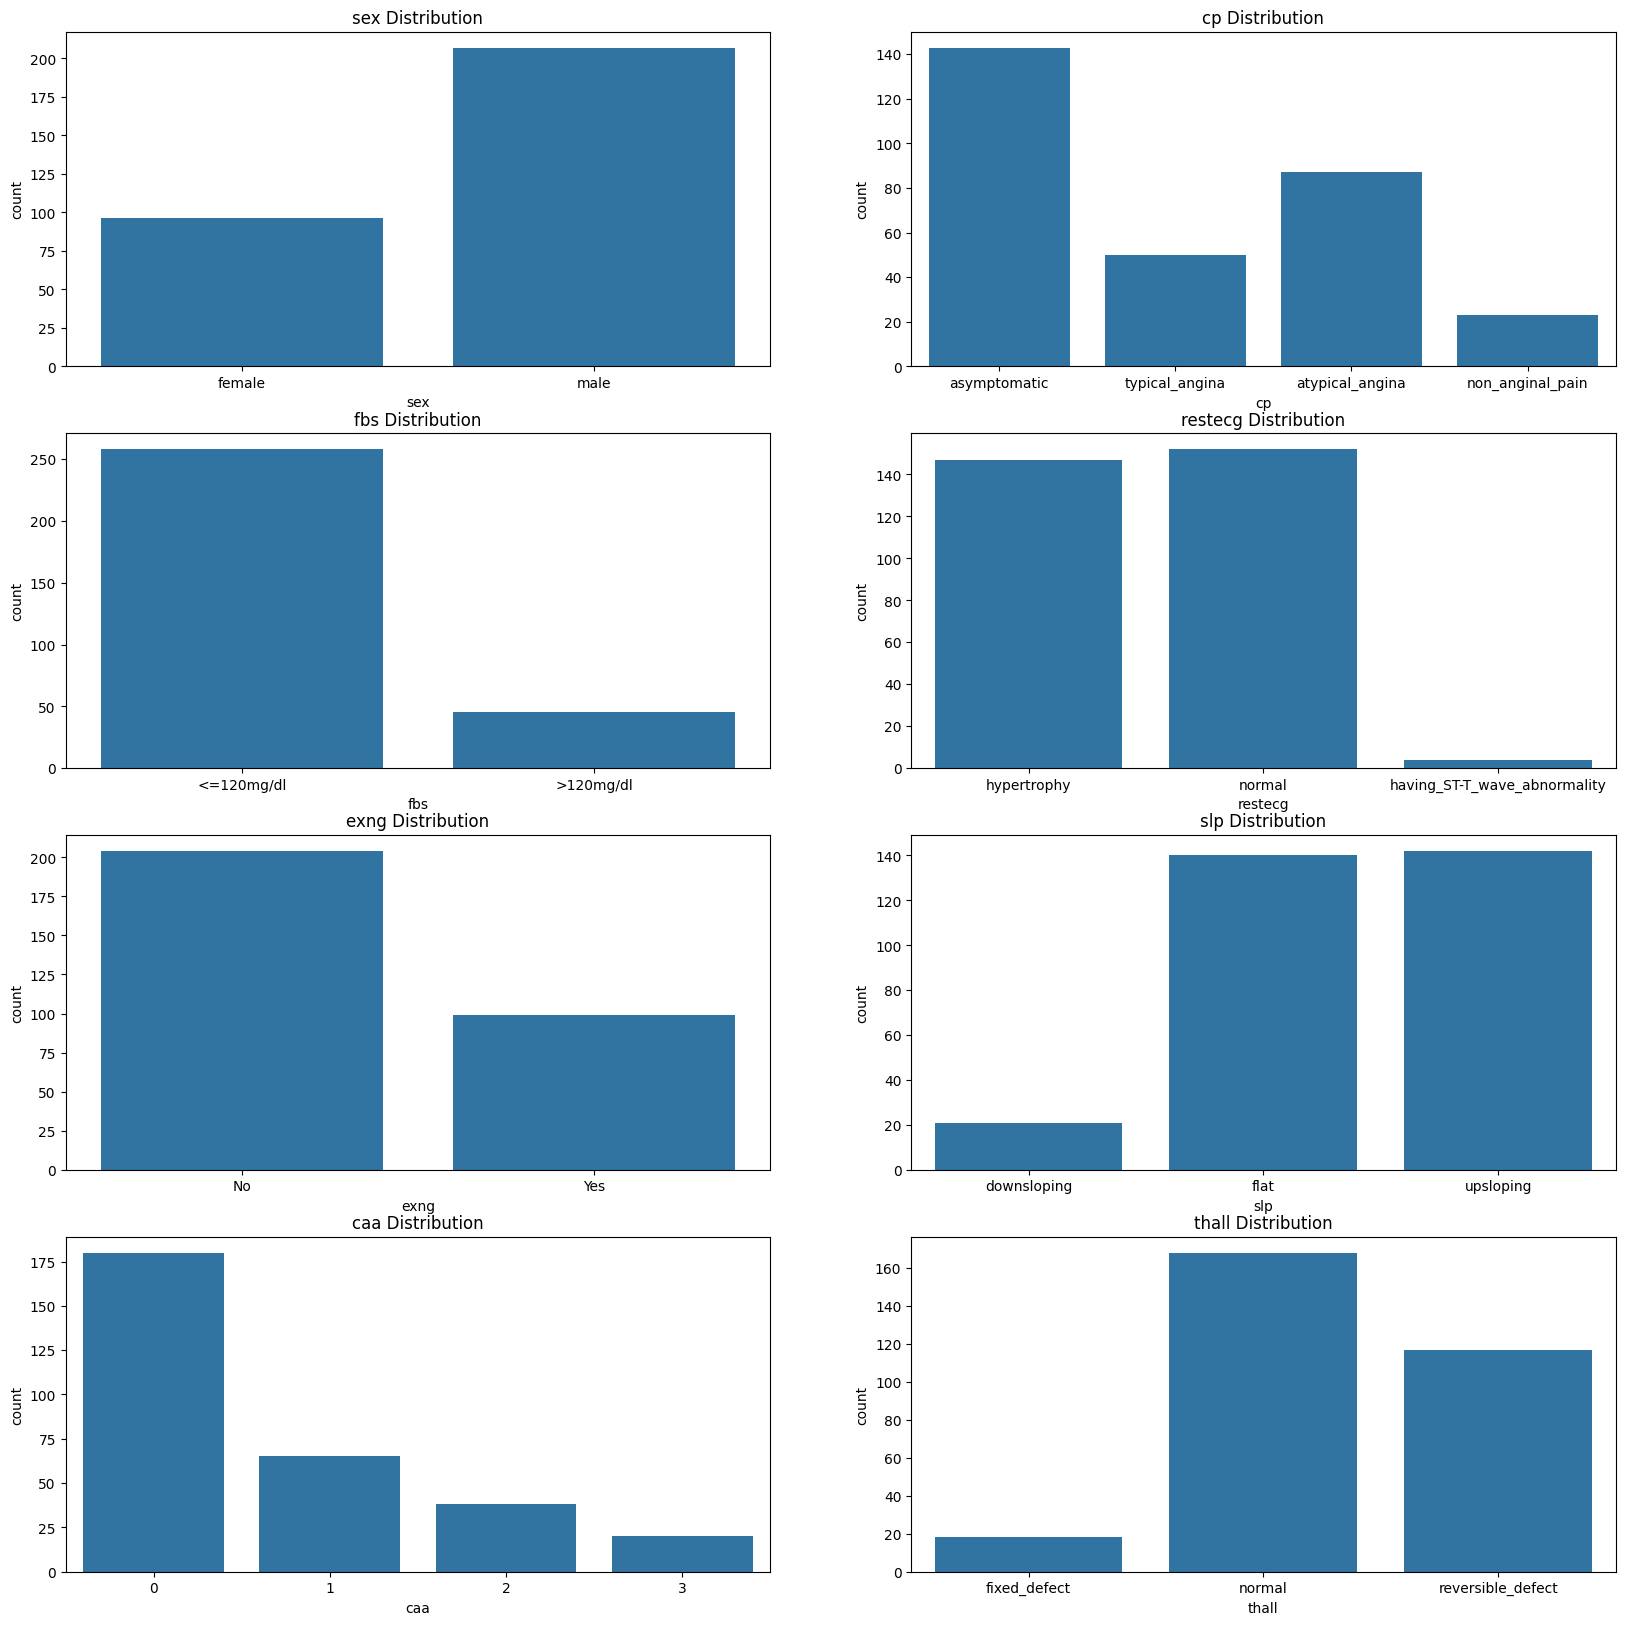

In [13]:
fix, axes = plt.subplots(4, 2, figsize=(20, 20))
for col in CATEGORICAL_COLS:
    sns.countplot(
        x=col,
        data=HEART_DATA,
        ax=axes[CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2],
    )
    axes[CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2].set_title(
        f"{col} Distribution"
    )
    axes[
        CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2
    ].set_xticklabels(
        [
            CATEGORY_MAP[col][int(t.get_text())]
            for t in axes[
                CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2
            ].get_xticklabels()
        ]
    )
plt.show()

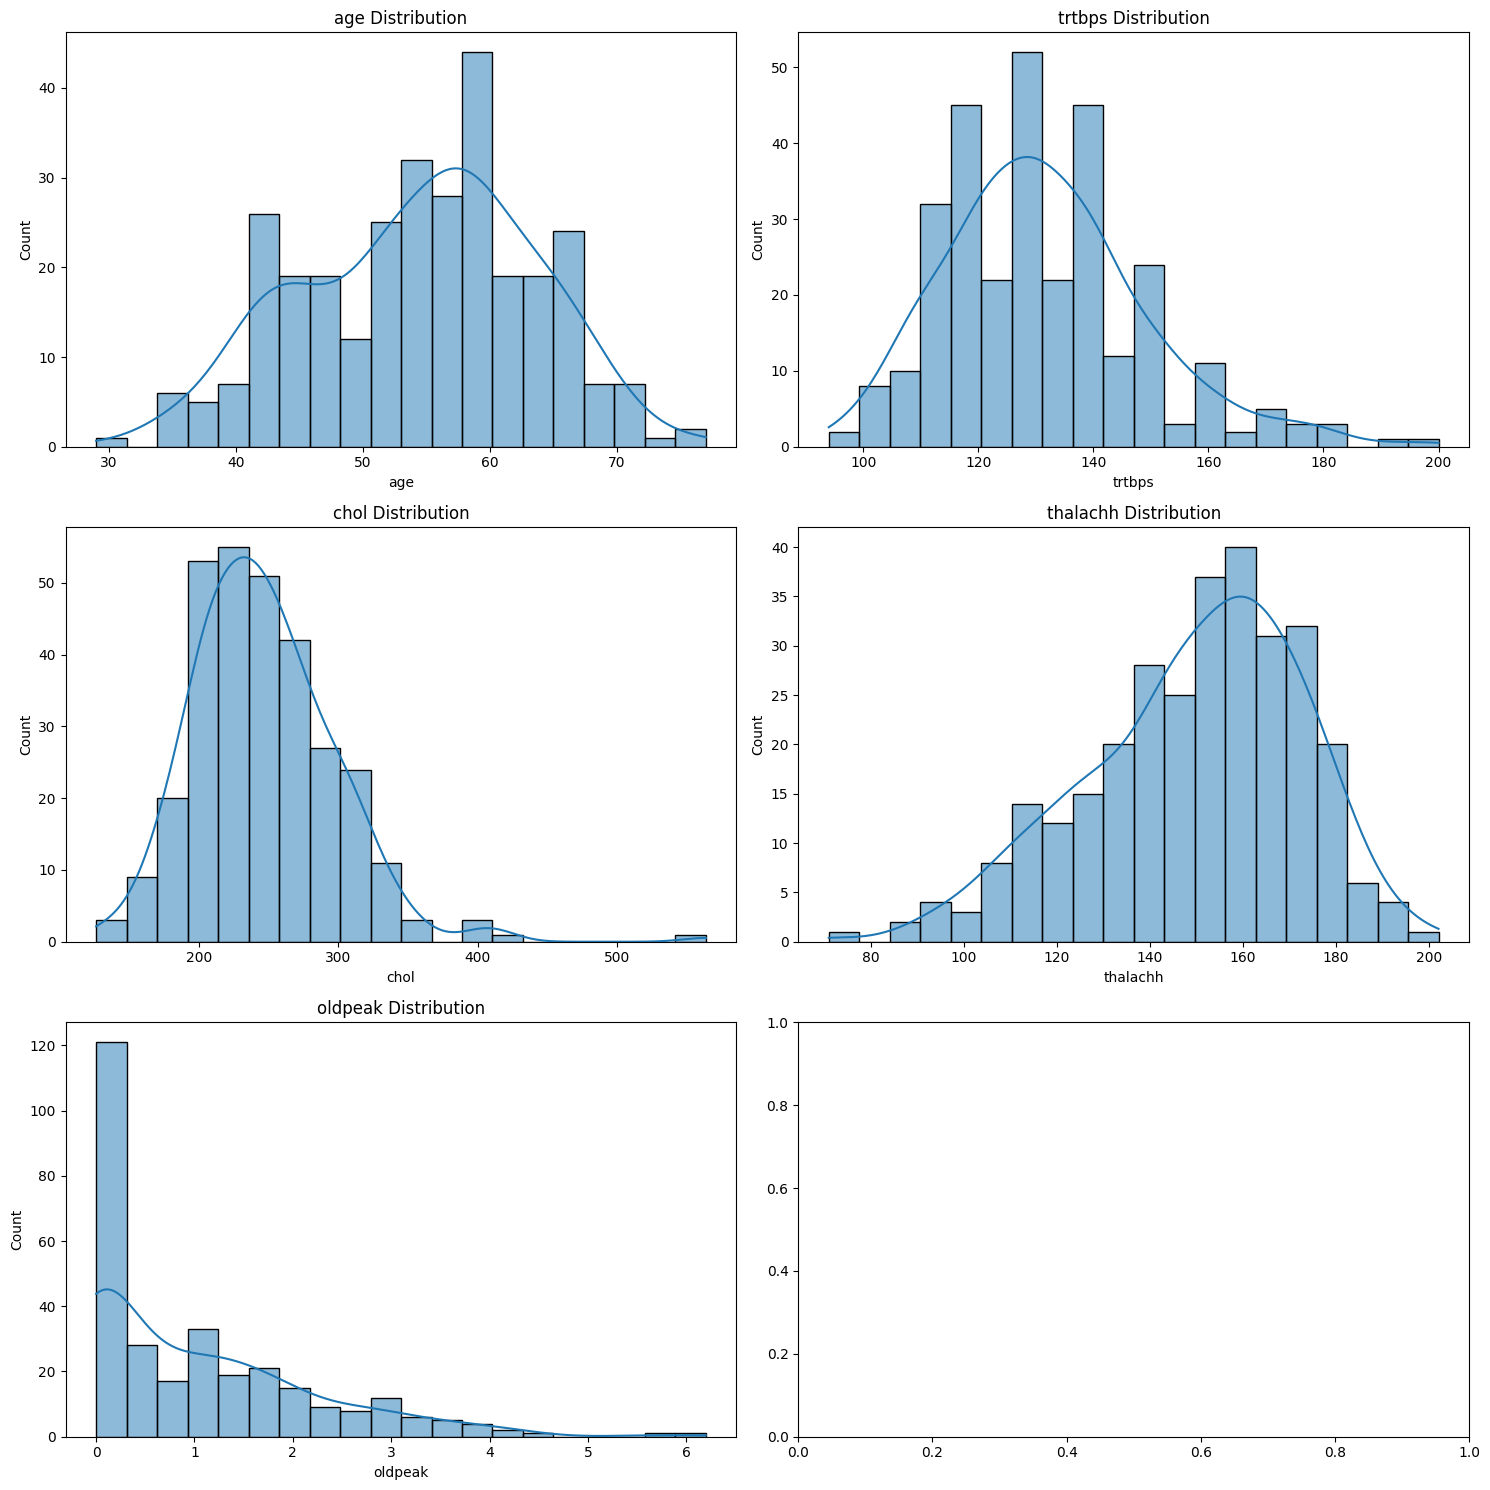

In [14]:
NUMERICAL_COLS = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
TARGET_COLUMN = 'output'
fig,axes = plt.subplots(3,2, figsize = (15,15))
r, c = 0,0
for column in NUMERICAL_COLS: 
    sns.histplot(HEART_DATA[column], kde=True, ax=axes[r,c], bins = 20)
    axes[r,c].set_title(f'{column} Distribution')
    c+=1
    if c == 2:
        c = 0
        r += 1

plt.tight_layout()
plt.show()

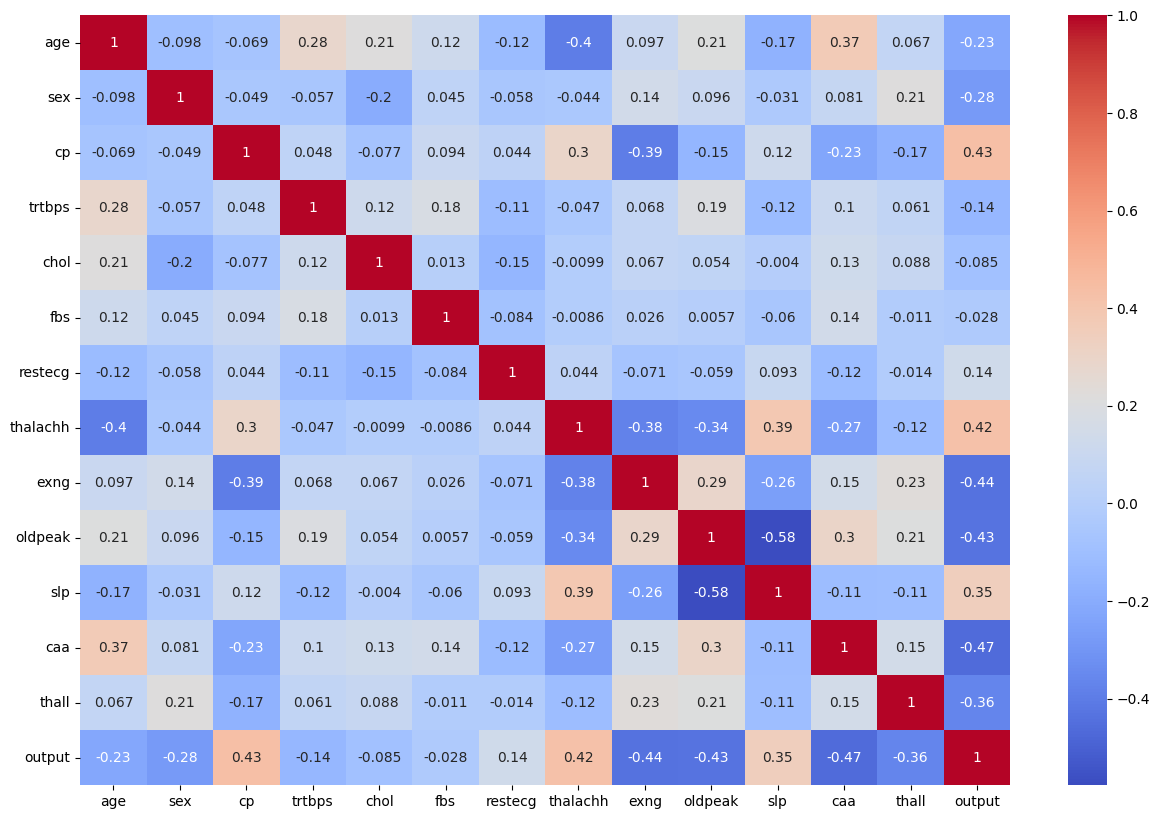

In [15]:
def plot_heat(df : pd.DataFrame):
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()

plot_heat(HEART_DATA)

# Association rule mining 

Before performing the ARM, I want to use clustering to add another column to the dataset with categories for age

In [16]:
HEART_DATA_ARM = HEART_DATA.copy()
ages = HEART_DATA_ARM[['age']]

#Scale the age for better clustering
scaler = StandardScaler()
ages_scaled = scaler.fit_transform(ages)

#Using KMeans to cluster the ages
kmeans = KMeans(n_clusters=4, random_state=42)
HEART_DATA_ARM['age_cluster'] = kmeans.fit_predict(ages_scaled)

#Want to see the age ranges for each cluster
HEART_DATA_ARM['age_cluster'] = HEART_DATA_ARM['age_cluster'].astype(int)  
age_cluster_ranges = HEART_DATA_ARM.groupby('age_cluster')['age'].agg(['min', 'max']).reset_index()
age_cluster_ranges

,age_cluster,min,max
0,0,29,46
1,1,56,63
2,2,47,55
3,3,64,77


Will then add a mapping from the age_clusters to a more descriptive name of each categoru to the category map. 

In [17]:
#do it more generic by ussing age_cluster_ranges
CATEGORY_MAP['age_cluster'] = {i: f"{age_cluster_ranges['min'][i]}_to_{age_cluster_ranges['max'][i]}" for i in range(4)}

### Find frequent itemsets

In [18]:
CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'age_cluster', 'output']
ENCODER, ENCODED_FEATURE_COLS, FEATURE_GROUPS = create_encoder(HEART_DATA_ARM, CATEGORICAL_COLS)
HEART_DATA_ONE_HOT = one_hot_encode_df(HEART_DATA_ARM, CATEGORICAL_COLS, ENCODER)
HEART_DATA_ONE_HOT_READABLE = make_readable_encoded_column_names(HEART_DATA_ONE_HOT, ENCODED_FEATURE_COLS.tolist(), CATEGORY_MAP)

In [19]:
HEART_DATA_ONE_HOT_READABLE

,age,trtbps,chol,thalachh,oldpeak,sex_female,sex_male,cp_asymptomatic,cp_typical_angina,cp_atypical_angina,...,caa_3,thall_fixed_defect,thall_normal,thall_reversible_defect,age_cluster_29_to_46,age_cluster_56_to_63,age_cluster_47_to_55,age_cluster_64_to_77,output_less_chance_of_heart_attack,output_more_chance_of_heart_attack
0,63,145,233,150,2.3,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,37,130,250,187,3.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,41,130,204,172,1.4,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,56,120,236,178,0.8,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,57,120,354,163,0.6,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
299,45,110,264,132,1.2,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
300,68,144,193,141,3.4,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
301,57,130,131,115,1.2,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [20]:
#Finding frequent itemsets for the categorical columns
CATEGORICAL_DATA_ONE_HOT = HEART_DATA_ONE_HOT_READABLE[HEART_DATA_ONE_HOT_READABLE.columns.difference(NUMERICAL_COLS + [TARGET_COLUMN])]
CATEGORICAL_DATA_ONE_HOT
FREQ_ITEMSETS = apriori(CATEGORICAL_DATA_ONE_HOT, min_support= 0.3, use_colnames=True)
ASSOCIATION_RULES = association_rules(FREQ_ITEMSETS, metric="confidence", min_threshold=0.4, num_itemsets=len(FREQ_ITEMSETS))
ASSOCIATION_RULES.to_csv('data/association_rules.csv')
ASSOCIATION_RULES[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(exng_No),(caa_0),0.445545,0.661765,1.113971
1,(caa_0),(exng_No),0.445545,0.750000,1.113971
2,(fbs_<=120mg/dl),(caa_0),0.524752,0.616279,1.037403
3,(caa_0),(fbs_<=120mg/dl),0.524752,0.883333,1.037403
4,(output_more_chance_of_heart_attack),(caa_0),0.442244,0.812121,1.367071
...,...,...,...,...,...
244,"(output_more_chance_of_heart_attack, fbs_<=120...","(exng_No, thall_normal)",0.333333,0.711268,1.584662
245,"(thall_normal, fbs_<=120mg/dl)","(exng_No, output_more_chance_of_heart_attack)",0.333333,0.687075,1.466082
246,(exng_No),"(output_more_chance_of_heart_attack, thall_nor...",0.333333,0.495098,1.304476
247,(output_more_chance_of_heart_attack),"(exng_No, thall_normal, fbs_<=120mg/dl)",0.333333,0.612121,1.558594


In [21]:
#Filtering strong association rules with lift > 1
STRONG_ASSOCIATION_RULES = ASSOCIATION_RULES[ASSOCIATION_RULES['lift'] > 1.0]
STRONG_ASSOCIATION_RULES = STRONG_ASSOCIATION_RULES.sort_values(by = "lift", ascending=False)
STRONG_ASSOCIATION_RULES.reset_index(drop=True, inplace=True)
STRONG_ASSOCIATION_RULES


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(output_more_chance_of_heart_attack, fbs_<=120...","(thall_normal, caa_0)",0.468647,0.392739,0.316832,0.676056,1.721387,1.0,0.132776,1.874587,0.788690,0.581818,0.466549,0.741390
1,"(thall_normal, caa_0)","(output_more_chance_of_heart_attack, fbs_<=120...",0.392739,0.468647,0.316832,0.806723,1.721387,1.0,0.132776,2.749175,0.690104,0.581818,0.636255,0.741390
2,"(exng_No, thall_normal, caa_0)",(output_more_chance_of_heart_attack),0.333333,0.544554,0.306931,0.920792,1.690909,1.0,0.125413,5.750000,0.612903,0.537572,0.826087,0.742214
3,(output_more_chance_of_heart_attack),"(exng_No, thall_normal, caa_0)",0.544554,0.333333,0.306931,0.563636,1.690909,1.0,0.125413,1.527778,0.897148,0.537572,0.345455,0.742214
4,"(exng_No, output_more_chance_of_heart_attack)","(thall_normal, caa_0)",0.468647,0.392739,0.306931,0.654930,1.667594,1.0,0.122875,1.759817,0.753423,0.553571,0.431759,0.718221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,(exng_No),(fbs_<=120mg/dl),0.673267,0.851485,0.577558,0.857843,1.007467,1.0,0.004281,1.044725,0.022684,0.609756,0.042810,0.768069
213,(fbs_<=120mg/dl),(exng_No),0.851485,0.673267,0.577558,0.678295,1.007467,1.0,0.004281,1.015627,0.049905,0.609756,0.015386,0.768069
214,"(sex_male, caa_0)",(fbs_<=120mg/dl),0.382838,0.851485,0.326733,0.853448,1.002306,1.0,0.000752,1.013395,0.003727,0.360000,0.013218,0.618585
215,"(exng_No, output_more_chance_of_heart_attack)",(fbs_<=120mg/dl),0.468647,0.851485,0.399340,0.852113,1.000737,1.0,0.000294,1.004243,0.001386,0.433692,0.004225,0.660552


### Correlation matrix of strong association rules 

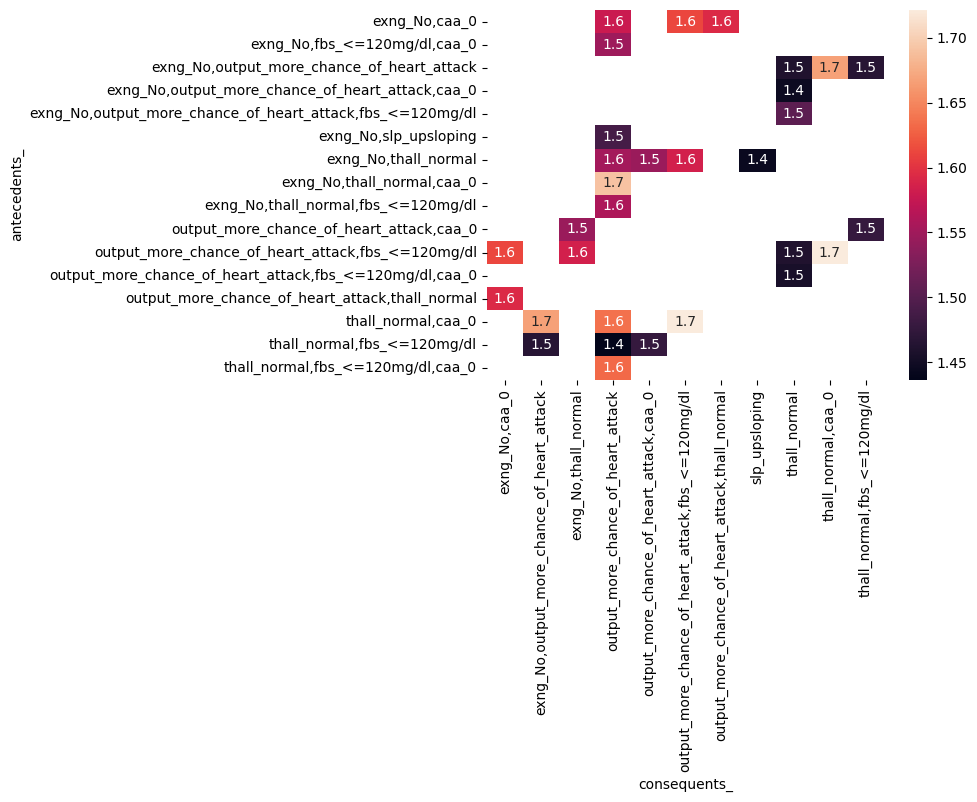

In [22]:
#Plotting a correlation matrix for the strong association rules where the number of items on the left hand side is greater than 1
MATRIX_STRONG_ASSOCIATION_RULES = STRONG_ASSOCIATION_RULES.copy()
MATRIX_STRONG_ASSOCIATION_RULES = MATRIX_STRONG_ASSOCIATION_RULES.head(50)
MATRIX_STRONG_ASSOCIATION_RULES["antecedents_len"] = MATRIX_STRONG_ASSOCIATION_RULES[
    "antecedents"
].apply(lambda x: len(x))
#MATRIX_STRONG_ASSOCIATION_RULES[
    #MATRIX_STRONG_ASSOCIATION_RULES["antecedents_len"] > 1
#].sort_values("lift", ascending=False).head()
MATRIX_STRONG_ASSOCIATION_RULES["antecedents_"] = MATRIX_STRONG_ASSOCIATION_RULES[
    "antecedents"
].apply(lambda a: ",".join(list(a)))
MATRIX_STRONG_ASSOCIATION_RULES["consequents_"] = MATRIX_STRONG_ASSOCIATION_RULES[
    "consequents"
].apply(lambda a: ",".join(list(a)))
pivot = MATRIX_STRONG_ASSOCIATION_RULES[
    MATRIX_STRONG_ASSOCIATION_RULES["antecedents_len"] > 1
].pivot(index="antecedents_", columns="consequents_", values="lift")
sns.heatmap(pivot, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [23]:
MATRIX_STRONG_ASSOCIATION_RULES

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_len,antecedents_,consequents_
0,"(output_more_chance_of_heart_attack, fbs_<=120...","(thall_normal, caa_0)",0.468647,0.392739,0.316832,0.676056,1.721387,1.0,0.132776,1.874587,0.788690,0.581818,0.466549,0.741390,2,"output_more_chance_of_heart_attack,fbs_<=120mg/dl","thall_normal,caa_0"
1,"(thall_normal, caa_0)","(output_more_chance_of_heart_attack, fbs_<=120...",0.392739,0.468647,0.316832,0.806723,1.721387,1.0,0.132776,2.749175,0.690104,0.581818,0.636255,0.741390,2,"thall_normal,caa_0","output_more_chance_of_heart_attack,fbs_<=120mg/dl"
2,"(exng_No, thall_normal, caa_0)",(output_more_chance_of_heart_attack),0.333333,0.544554,0.306931,0.920792,1.690909,1.0,0.125413,5.750000,0.612903,0.537572,0.826087,0.742214,3,"exng_No,thall_normal,caa_0",output_more_chance_of_heart_attack
3,(output_more_chance_of_heart_attack),"(exng_No, thall_normal, caa_0)",0.544554,0.333333,0.306931,0.563636,1.690909,1.0,0.125413,1.527778,0.897148,0.537572,0.345455,0.742214,1,output_more_chance_of_heart_attack,"exng_No,thall_normal,caa_0"
4,"(exng_No, output_more_chance_of_heart_attack)","(thall_normal, caa_0)",0.468647,0.392739,0.306931,0.654930,1.667594,1.0,0.122875,1.759817,0.753423,0.553571,0.431759,0.718221,2,"exng_No,output_more_chance_of_heart_attack","thall_normal,caa_0"
5,"(thall_normal, caa_0)","(exng_No, output_more_chance_of_heart_attack)",0.392739,0.468647,0.306931,0.781513,1.667594,1.0,0.122875,2.431962,0.659245,0.553571,0.588809,0.718221,2,"thall_normal,caa_0","exng_No,output_more_chance_of_heart_attack"
6,(output_more_chance_of_heart_attack),"(thall_normal, caa_0)",0.544554,0.392739,0.349835,0.642424,1.635752,1.0,0.135967,1.698272,0.853363,0.595506,0.411166,0.766590,1,output_more_chance_of_heart_attack,"thall_normal,caa_0"
7,"(thall_normal, caa_0)",(output_more_chance_of_heart_attack),0.392739,0.544554,0.349835,0.890756,1.635752,1.0,0.135967,4.169078,0.640023,0.595506,0.760139,0.766590,2,"thall_normal,caa_0",output_more_chance_of_heart_attack
8,(output_more_chance_of_heart_attack),"(thall_normal, fbs_<=120mg/dl, caa_0)",0.544554,0.356436,0.316832,0.581818,1.632323,1.0,0.122733,1.538958,0.850543,0.542373,0.350210,0.735354,1,output_more_chance_of_heart_attack,"thall_normal,fbs_<=120mg/dl,caa_0"
9,"(thall_normal, fbs_<=120mg/dl, caa_0)",(output_more_chance_of_heart_attack),0.356436,0.544554,0.316832,0.888889,1.632323,1.0,0.122733,4.099010,0.601923,0.542373,0.756039,0.735354,3,"thall_normal,fbs_<=120mg/dl,caa_0",output_more_chance_of_heart_attack


In [24]:


antecedents = STRONG_ASSOCIATION_RULES['antecedents'].apply(lambda x: ', '.join(list(x))).tolist()
consequents = STRONG_ASSOCIATION_RULES['consequents'].apply(lambda x: ', '.join(list(x))).tolist()
lifts = STRONG_ASSOCIATION_RULES['lift']

nodes = list(set(antecedents + consequents))
node_indicies = {node: i for i, node in enumerate(nodes)}

links = []
for ancentent, consequent, lift in zip(antecedents, consequents, lifts):
    links.append({
        'source': node_indicies[ancentent],
        'target': node_indicies[consequent],
        'value': lift
    })

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes
    ),
    link = dict(
      source = [link['source'] for link in links],
      target = [link['target'] for link in links],
      value = [link['value'] for link in links],
      color = 'blue',
    ))])
fig.update_layout(title_text="Sankey Diagram for Association Rules", font_size=10)
fig.show()

### Graph of the top 50 strong association rules

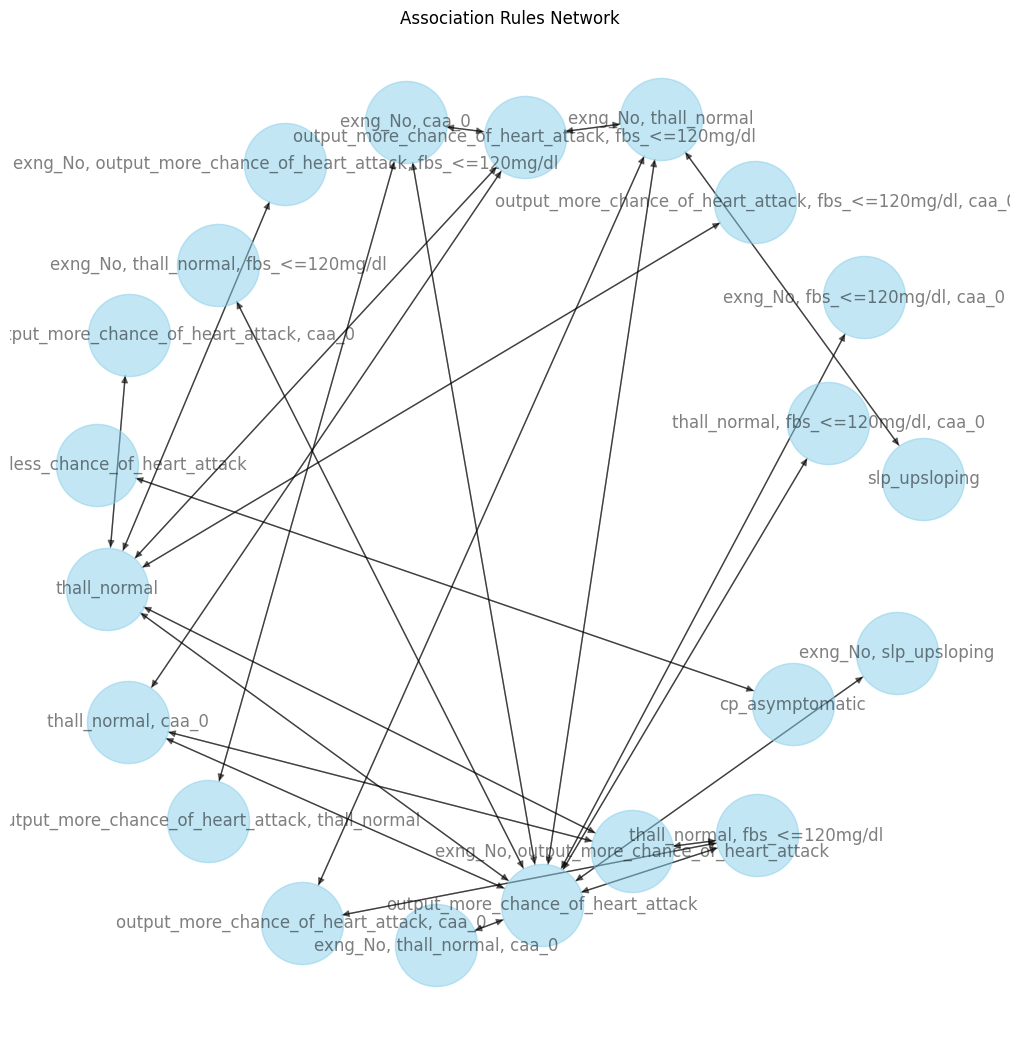

In [25]:
GRAPH_STRONG_ASSOCIATON_RULES = STRONG_ASSOCIATION_RULES.copy().head(50)
GRAPH_STRONG_ASSOCIATON_RULES["antecedents"] = GRAPH_STRONG_ASSOCIATON_RULES[
    "antecedents"
].apply(lambda x: ", ".join(list(x)))
GRAPH_STRONG_ASSOCIATON_RULES["consequents"] = GRAPH_STRONG_ASSOCIATON_RULES[
    "consequents"
].apply(lambda x: ", ".join(list(x)))

G = nx.from_pandas_edgelist(
    GRAPH_STRONG_ASSOCIATON_RULES,
    source="antecedents",
    target="consequents",
    edge_attr=True,
    create_using=nx.DiGraph(),
)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=4, seed=1)
nx.draw(G, with_labels=True, node_size=3500, node_color="skyblue", node_shape="o", alpha=0.5, pos=pos, arrows=True)
plt.title("Association Rules Network")
plt.show()

### Scatter plot metrics from ARM

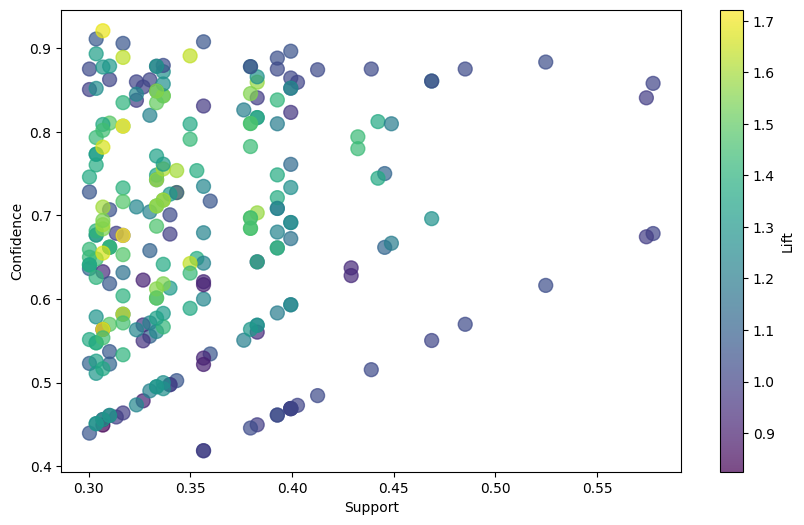

In [26]:
# Create the scatter plot of association rules
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    ASSOCIATION_RULES["support"],
    ASSOCIATION_RULES["confidence"],
    c=ASSOCIATION_RULES["lift"],
    cmap="viridis",
    s=100,
    alpha=0.7,
)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.colorbar(scatter, label="Lift")

We can observe that the associatoon rules with a high lift have a relatively low support. 

# Clustering